In [7]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
import scipy
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [145]:
# Functions for graphs we would like to visualize. We do this since each graph may need to be visualized differently.

def get_complete_graph(n):
    G = nx.complete_graph(n)
    return G, nx.drawing.spring_layout(G)

def get_barbell_graph(n):
    G = nx.barbell_graph(n, 0)
    return G, nx.drawing.spring_layout(G, iterations=100)

def get_2d_graph(n):
    G = nx.grid_2d_graph(n, n)
    return G, nx.drawing.spring_layout(G, iterations=100)


In [ ]:
# Diffusion on the c
G, layout = get_barbell_graph(5)
lap = nx.laplacian_matrix(G).toarray()
def visualize_diffusion_kernel(beta):
    kernel = scipy.linalg.expm(lap*beta)
    nx.draw(G, pos=layout, node_color=kernel[0, :], cmap='hot', vmin=-100, vmax=100)
    plt.show()
    
interact(visualize_diffusion_kernel, beta=(-2.0, 5.0))

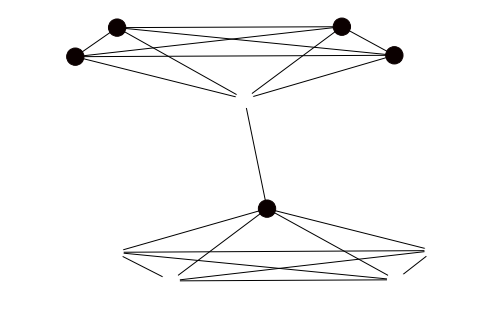

In [154]:
# Diffusion on barbell (dumbbell) graph
G, layout = get_barbell_graph(5)
lap = nx.laplacian_matrix(G).toarray()
def visualize_diffusion_kernel(beta):
    kernel = scipy.linalg.expm(lap*beta)
    nx.draw(G, pos=layout, node_color=kernel[0, :], cmap='hot', vmin=-100, vmax=100)
    plt.show()
    
interact(visualize_diffusion_kernel, beta=(-2.0, 5.0))

In [136]:
# Random Walk
def lazy_random_walk_step(p, G):
    '''
        Given a dist p, take one step of the lazy RW.
        p = 
    '''

    n = len(G.nodes())
    A = nx.adjacency_matrix(G).toarray()
    D = nx.laplacian_matrix(G).toarray() + A
    # Lazy Random Walk Matrix
    W = 0.5*(np.eye(n) + np.dot(A,  np.linalg.inv(D)))
    return np.dot(W, p)

p = np.zeros(len(G.nodes()), dtype=np.float32)
p[0] = 1.0
print(p)
p = lazy_random_walk_step(p, G)
print(p*100)



[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[50. 25.  0.  0.  0.  0.  0.  0.  0.  0. 25.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
